# Media

## Introduction


**skrf** supports some basic circuit simulation based on transmission line models. Network creation is accomplished through methods of the [Media](../api/media/index.rst) class, which represents a transmission line object for a given medium. Once constructed, a [Media](../api/media/index.rst) object contains the neccesary properties such as `propagation constant` and `characteristic impedance`, that are needed to generate microwave networks.

This tutorial illustrates how created Networks using several different [Media](../api/media/index.rst) objects. The basic usage is, 

In [2]:
import skrf as rf
from skrf import Frequency
from skrf.media import CPW

freq = Frequency(75,110,101,'ghz')
cpw =  CPW(freq, w=10e-6, s=5e-6, ep_r=10.6)
cpw

Coplanar Waveguide Media.  75-110 GHz.  101 points
 W= 1.00e-05m, S= 5.00e-06m

To create a transmission line of 100um

In [4]:
cpw.line(100*1e-6, name = '100um line')

/home/alex/code/scikit-rf/skrf/media/media.py:282: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return 1.0*theta/npy.imag(gamma[gamma.size/2])


2-Port Network: '100um line',  75-110 GHz, 101 pts, z0=[ 50.06074662+0.j  50.06074662+0.j]

More detailed examples illustrating how to create various kinds of [Media](../api/media/index.rst) 
objects are given below. A full list of media's supported can be found in the  [Media](../api/media/index.rst) API page. The network creation and connection syntax of **skrf** are cumbersome  if you need to doing complex circuit design. **skrf**'s synthesis cabilities lend themselves more to scripted applications such as calibration, optimization or batch processing.

##  [Media](../api/media/index.rst) Object Basics 

Two arguments are common to all media constructors

* `frequency` (required)
*  `z0`   (optional)

`frequency` is  a `Frequency` object, and `z0` is the port impedance. `z0` is only needed if the port impedance is different from the media's characteristic impedance. Here is an example of how to initialize a coplanar waveguide [0] media. The instance has  a 10um center conductor, gap of 5um, and substrate with relative permativity of 10.6,

In [12]:
freq = Frequency(75,110,101,'ghz')
cpw = CPW(freq, w=10e-6, s=5e-6, ep_r=10.6, z0 =1)

cpw

Coplanar Waveguide Media.  75-110 GHz.  101 points
 W= 1.00e-05m, S= 5.00e-06m

For the purpose of microwave network analysis, the defining properties of a (single moded) transmisison line are it's characteristic impedance and propagation constant. These properties return complex `numpy.ndarray`'s,  A *port impedance* is also needed when different networks are connected. 

The *characteristic impedance* is given by a `Z0` (capital Z)

In [13]:
cpw.Z0[:3] 

array([ 50.06074662+0.j,  50.06074662+0.j,  50.06074662+0.j])

The *port impedance* is given by `z0` (lower z).  Which we set to 1, just to illustrate how this works. The *port impedance* is used to compute impednace mismatched if circuits of different port impedance are connected. 

In [14]:
cpw.z0[:3]

array([ 1.,  1.,  1.])

The propagation constant is given by `gamma` 

In [17]:
cpw.gamma[:3]

array([ 0.+3785.59740815j,  0.+3803.26352939j,  0.+3820.92965062j])

Lets take a look at some other [Media](../api/media/index.rst)'s

## Slab of  Si in Freespace

A plane-wave in freespace from 10-20GHz.

In [27]:
from skrf.media import Freespace

freq = Frequency(10,20,101,'ghz')
air =  Freespace(freq)
air

Freespace  Media.  10-20 GHz.  101 points

In [28]:
air.z0[:2] # 377ohm baby!

array([ 376.73031346+0.j,  376.73031346+0.j])

In [29]:
# plane wave in Si
si = Freespace(freq, ep_r = 11.2)
si.z0[:3] # ~110ohm


array([ 112.56971216+0.j,  112.56971216+0.j,  112.56971216+0.j])

Simpulate a 1cm slab of Si in half-space,

/home/alex/code/scikit-rf/skrf/media/media.py:282: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return 1.0*theta/npy.imag(gamma[gamma.size/2])


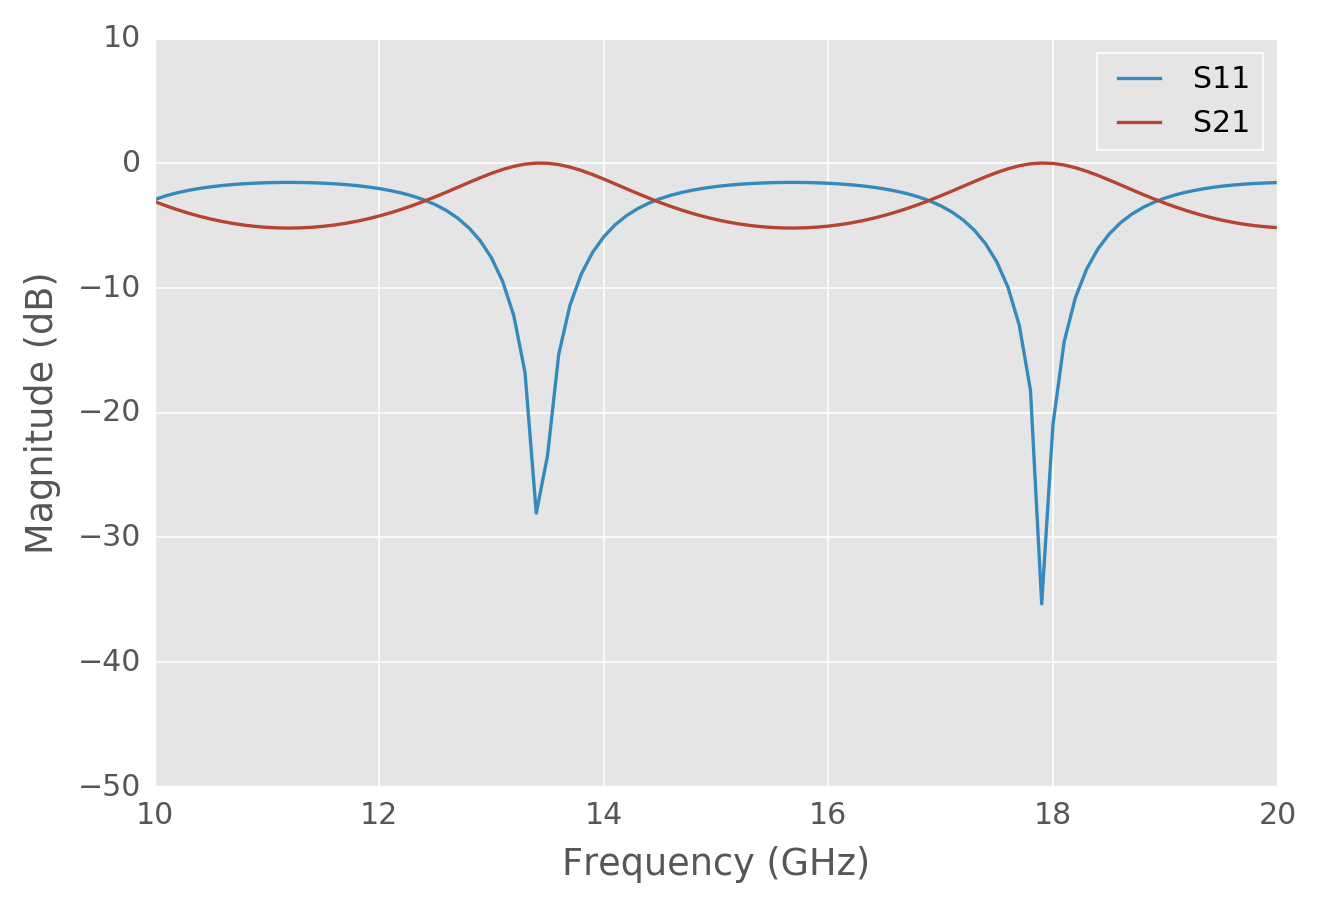

In [35]:
slab = air.thru() ** si.line(1, 'cm') ** air.thru()
slab.plot_s_db(n=0)

## Rectangular Waveguide

a WR-10 Rectangular Waveguide

In [56]:
from skrf.media import RectangularWaveguide

freq = Frequency(75,110,101,'ghz')
wg = RectangularWaveguide(freq, a=100*rf.mil, z0=50) # see note below about z0
wg

Rectangular Waveguide Media.  75-110 GHz.  101 points
 a= 2.54e-03m, b= 1.27e-03m

The `z0` argument in the Rectangular Waveguide constructor is used
to force a specifc port impedance. This is commonly used to match 
the port impedance to what a VNA stores in a touchstone file. Lets compare the propagation constant in waveguide to that of freespace, 

In [57]:
air = Freespace(freq)

/home/alex/code/scikit-rf/skrf/media/rectangularWaveguide.py:353: RuntimeWarning: invalid value encountered in sqrt
  -1j*sqrt(1-self.f_norm**(2))*fs.gamma)# cutoff


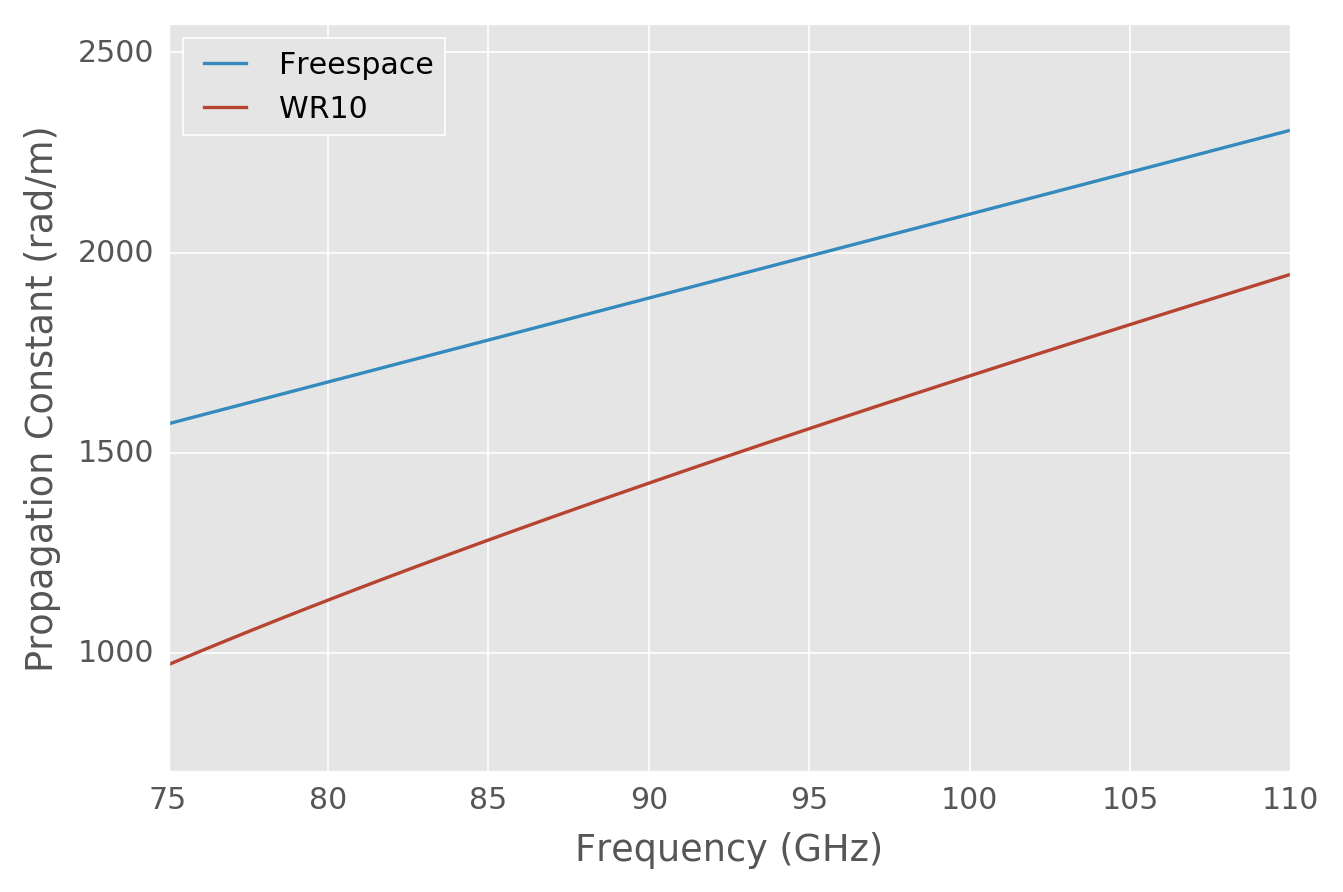

In [58]:
from matplotlib import pyplot as plt

air.plot(air.gamma.imag, label='Freespace')
wg.plot(wg.gamma.imag, label='WR10')

plt.ylabel('Propagation Constant (rad/m)')
plt.legend()

Because the wave quantities are dynamic they change when the attributes 
of the media change. To illustrate, plot the propagation constant of the cpw for various values of substrated permativity,  

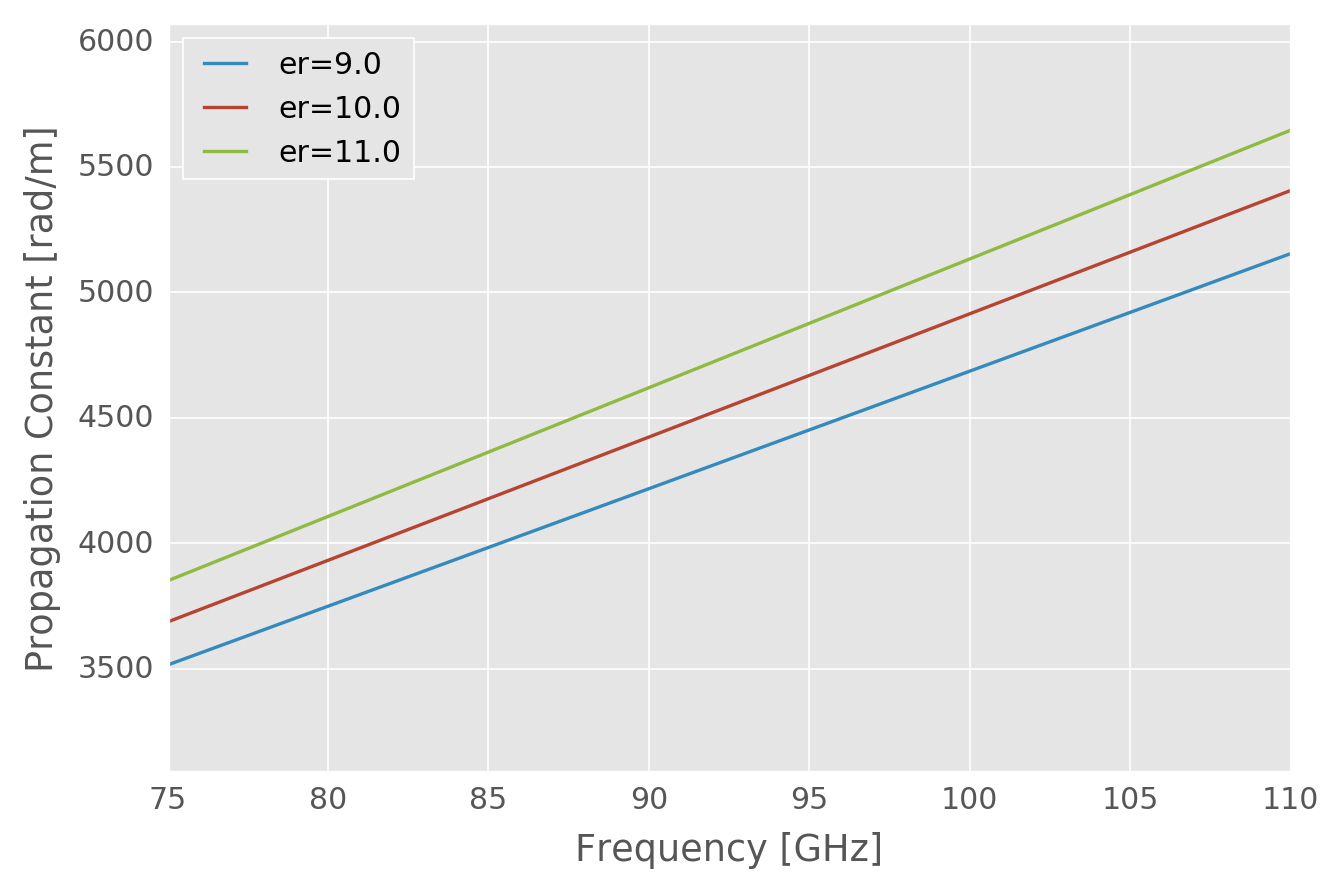

In [59]:
for ep_r in [9,10,11]:
    cpw.ep_r = ep_r
    cpw.frequency.plot(cpw.beta, label='er=%.1f'%ep_r)

plt.xlabel('Frequency [GHz]')
plt.ylabel('Propagation Constant [rad/m]')
plt.legend()


## Network Synthesis

Networks are created through methods of a Media object. To create a 1-port network for a rectangular waveguide short, 

In [62]:
wg.short(name = 'short') 

1-Port Network: 'short',  75-110 GHz, 101 pts, z0=[ 50.+0.j]

Or to create a $90^{\circ}$ section of cpw line, 

In [64]:
cpw.line(d=90,unit='deg', name='line')

/home/alex/code/scikit-rf/skrf/media/media.py:282: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return 1.0*theta/npy.imag(gamma[gamma.size/2])


2-Port Network: 'line',  75-110 GHz, 101 pts, z0=[ 1.+0.j  1.+0.j]

## Building Cicuits


By connecting a series of simple circuits, more complex circuits can be 
made. To build a the $90^{\circ}$ delay short, in the 
rectangular waveguide media defined above.

In [65]:
delay_short = wg.line(d=90,unit='deg') ** wg.short()
delay_short.name = 'delay short'
delay_short

/home/alex/code/scikit-rf/skrf/media/rectangularWaveguide.py:353: RuntimeWarning: invalid value encountered in sqrt
  -1j*sqrt(1-self.f_norm**(2))*fs.gamma)# cutoff
/home/alex/code/scikit-rf/skrf/media/media.py:282: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return 1.0*theta/npy.imag(gamma[gamma.size/2])


1-Port Network: 'delay short',  75-110 GHz, 101 pts, z0=[ 50.+0.j]

When `Networks` with more than 2 ports need to be connected together, use 
`rf.connect()`.  To create a two-port network for a shunted delayed open, you can create an ideal 3-way splitter (a 'tee') and conect the delayed open to one of its ports,
	

In [66]:
tee = cpw.tee()
delay_open = cpw.delay_open(40,'deg')
shunt_open = rf.connect(tee,1,delay_open,0)

/home/alex/code/scikit-rf/skrf/media/media.py:282: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return 1.0*theta/npy.imag(gamma[gamma.size/2])


Adding networks in shunt  is pretty common, so there is a `Media.shunt()` function to do this, 

In [72]:
cpw.shunt(delay_open)

2-Port Network: '',  75-110 GHz, 101 pts, z0=[ 1.+0.j  1.+0.j]

If a specific circuit is created frequently, it may make sense to 
use a function to create the circuit. This can be done most quickly using `lambda`

In [69]:
delay_short = lambda d: wg.line(d,'deg')**wg.short()
delay_short(90)

/home/alex/code/scikit-rf/skrf/media/rectangularWaveguide.py:353: RuntimeWarning: invalid value encountered in sqrt
  -1j*sqrt(1-self.f_norm**(2))*fs.gamma)# cutoff
/home/alex/code/scikit-rf/skrf/media/media.py:282: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return 1.0*theta/npy.imag(gamma[gamma.size/2])


1-Port Network: '',  75-110 GHz, 101 pts, z0=[ 50.+0.j]

A more useful example may be to create a function for a shunt-stub tuner,
that will work for any media object

In [73]:
def shunt_stub(med, d0, d1):
    return med.line(d0,'deg')**med.shunt_delay_open(d1,'deg')

shunt_stub(cpw,10,90)

/home/alex/code/scikit-rf/skrf/media/media.py:282: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return 1.0*theta/npy.imag(gamma[gamma.size/2])


2-Port Network: '',  75-110 GHz, 101 pts, z0=[ 1.+0.j  1.+0.j]

This approach lends itself to design optimization.

## Design Optimization


The abilities of `scipy`'s optimizers can be used to automate network design. In this example, skrf is used to automate the single stub impedance matching network design. First, we create a 'cost' function which returns somthing we want to minimize, such as the reflection coefficient magnitude at band center. Then, one of scipy's minimization algorithms is used to determine the optimal parameters of the stub lengths to minimize this cost.

In [81]:
from scipy.optimize import fmin

# the load we are trying to match
load = cpw.load(.2+.2j)

# single stub circuit generator function
def shunt_stub(med, d0, d1):
    return med.line(d0,'deg')**med.shunt_delay_open(d1,'deg')


# define the cost function we want to minimize (this uses sloppy namespace)
def cost(d):
    # prevent negative length lines, returning high cost
    if d[0] <0 or d[1] <0:
        return 1e3 
    return (shunt_stub(cpw,d[0],d[1]) ** load)[100].s_mag.squeeze()

# initial guess of optimal delay lengths in degrees
d0 = 120,40 # initial guess

#determine the optimal delays
d_opt = fmin(cost,(120,40))

d_opt 

/home/alex/code/scikit-rf/skrf/media/media.py:282: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return 1.0*theta/npy.imag(gamma[gamma.size/2])


Optimization terminated successfully.
         Current function value: 0.233333
         Iterations: 55
         Function evaluations: 117


array([ 174.64783289,   12.71791552])